# Fold test of paleomagnetic directions

In [1]:
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.ipmag as ipmag
import matplotlib.pyplot as plt # our plotting buddy
from pmagpy import convert_2_magic as convert
import numpy as np # the fabulous NumPy package
import pandas as pd # and of course Pandas
has_basemap, Basemap = pmag.import_basemap()
has_cartopy, Cartopy = pmag.import_cartopy()
from IPython.display import Image
%matplotlib inline 

### Function definitions

In [2]:
#define a fisher mean of sites_means function
def fisher_sites_mean(di_block,alpha95,n, tc: bool):
    mode_1,mode_2=pmag.separate_directions(di_block) #mode_1,mode_2: 2 arrays of nested dec,inc pairs
    # Calculates the Fisher mean and associated parameters
    fpars=ipmag.fisher_mean(di_block=di_block)
   
    # Build a dataframe with fisher statistics of all modes and the overall mean
    mean = pd.DataFrame(fpars,index = ["all sites"])
  
    #arrange columns in dataframe
    cols = mean.columns.tolist()
    cols = cols[2:3] + cols[:2] + cols[3:]
    mean = mean[cols]
    if tc == False:
        mean = mean.rename(columns = {cols[1]:'Dg', cols[2]:'Ig'})
        title = 'Geographic coordinates'
    else:
        mean = mean.rename(columns = {cols[1]:'Ds', cols[2]:'Is'})
        title = 'Stratigraphic coordinates'
    mean = mean.round(2)
    
    # plot the data
    ipmag.plot_net(n)
    
    alpha95 = np.transpose(alpha95)
    di_a = np.concatenate((di_block, alpha95), axis=1)
    for n in range(len(di_a)):
        ipmag.plot_di_mean(dec=di_a[n,0],inc=di_a[n,1],a95=di_a[n,2],\
                  color='green',markersize=50)
    
    # draw on the means and lpha95
    ipmag.plot_di_mean(dec=fpars['dec'],inc=fpars['inc'],a95=fpars['alpha95'],\
                  marker='*',color='black',markersize=200)
    plt.text(0,1,title)
    return mean

In [3]:
#define get site mean bedding orientation from di_g and di_s
def di_bedding(dec_inc_g,dec_inc_s):
    cart_g = pmag.dir2cart(dec_inc_g) #returns cartesian coordinates of in situ pmag directions [N,E,down]
    cart_s = pmag.dir2cart(dec_inc_s) #returns cartesian coordinates of tc corrected pmag directions [N,E,down]
    cart_vector_substraction = cart_g - cart_s   # vector contained in small circle perpendicular to strike
    
    # bedding strike from cross product of Z axis and  cart_vector_substraction (right hand rule)
    strike = pmag.cart2dir(np.cross(cart_vector_substraction, (0,0,-1))).round()
    strike = strike.transpose()[0]
    dipdir = strike + 90
    
    #change coordinates N2 axis == bedding strike
    new_coord_cart_g =np.array([[np.sqrt(np.square(cart_g[:,0])+np.square(cart_g[:,1]))*np.cos(np.radians(di_g[:,0]-strike))],
                            [np.sqrt(np.square(cart_g[:,0])+np.square(cart_g[:,1]))*np.sin(np.radians(dec_inc_g[:,0]-strike))],
                            [cart_g[:,2]]]).transpose()
    new_coord_cart_s =np.array([[np.sqrt(np.square(cart_s[:,0])+np.square(cart_s[:,1]))*np.cos(np.radians(di_s[:,0]-strike))],
                            [np.sqrt(np.square(cart_s[:,0])+np.square(cart_s[:,1]))*np.sin(np.radians(dec_inc_s[:,0]-strike))],
                            [cart_s[:,2]]]).transpose()
    
    
    #calculate bedding dip (=angle between projections of di_g and di-s on the dip-direction vertical plane)
    module = np.zeros((len(new_coord_cart_g),1)) #module of the vector substraction (di_g - di_s)
    substract = new_coord_cart_g - new_coord_cart_s
    for n in range(len(module)):
            module[n] = np.linalg.norm(substract[n])
    
    dip = np.degrees(2*np.arcsin(module/2))
    dip = dip.transpose()[0]
    bedding = np.stack((dipdir,dip), axis=-1)
    return bedding
    

In [4]:
#define a syn_fisher_means function
def syn_fisher_means(di_block):
    mode_1,mode_2=pmag.separate_directions(di_block) #mode_1,mode_2: 2 arrays of nested dec,inc pairs
    
    mode_1_fpars=ipmag.fisher_mean(di_block=mode_1) # Calculates the Fisher mean and associated parameters of mode 1
    mode_2_fpars=ipmag.fisher_mean(di_block=mode_2)

    # Calculates the Fisher mean of all_to_single_mode directions.
    if mode_2.any():
        to_single_mode_2_dec=mode_2.transpose()[0]+180 # all_to_single mode: all directions shifted to one polarity
        to_single_mode_2_inc= - mode_2.transpose()[1]
        to_single_mode_2 = np.array([to_single_mode_2_dec,to_single_mode_2_inc]).transpose()
        all_to_single = np.concatenate((mode_1,to_single_mode_2))
        all_to_single_fpars =ipmag.fisher_mean(di_block=all_to_single)
    else:
        all_to_single_fpars = mode_1_fpars
    syn_mean = all_to_single_fpars        
    return syn_mean

### Reading input excel file

In [5]:
#reading data from excel spreadsheets and importing into a single dataframe

xls = pd.ExcelFile('ripoll_syncline_means.xlsx')
datafile1 = xls.parse(0)
#unmark if more files need to be added
#xls = pd.ExcelFile('')
#datafile2 = xls.parse(0)
#collecteddata = pd.concat([datafile1,datafile2])
foldtestdata = datafile1
foldtestdata.rename(columns={'Unnamed: 0': 'Site', 'n.1':'n.s','r.1':'r.s', 'k.1':'k.s','alpha95.1':'alpha95.s','csd.1':'csd.s'}, inplace=True)
foldtestdata = foldtestdata.reset_index(drop = True)
#foldtestdata = foldtestdata.set_index('Site')

In [6]:
foldtestdata

,Site,n,Dg,Ig,r,k,alpha95,csd,n.s,Ds,Is,r.s,k.s,alpha95.s,csd.s
0,Pobla Lillet,21,5.6,-3.1,16.3,4.3,17.5,39.1,21,6.1,33.1,17.5,5.8,14.5,33.8
1,Borredà,31,227.6,79.3,26.8,7.1,10.4,30.3,31,331.8,50.1,26.9,7.4,10.2,29.8
2,Gombren,37,8.0,26.4,31.4,6.4,10.1,32.0,37,5.5,60.4,31.1,6.1,10.4,32.8
3,SJF,176,337.7,76.4,156.3,8.9,3.8,27.2,176,347.8,37.3,157.9,9.7,3.6,26.0


### Fisher means

,Site,n,Dg,Ig,r,k,alpha95,csd,n.s,Ds,Is,r.s,k.s,alpha95.s,csd.s
0,Pobla Lillet,21,5.6,-3.1,16.3,4.3,17.5,39.1,21,6.1,33.1,17.5,5.8,14.5,33.8
1,Borredà,31,227.6,79.3,26.8,7.1,10.4,30.3,31,331.8,50.1,26.9,7.4,10.2,29.8
2,Gombren,37,8.0,26.4,31.4,6.4,10.1,32.0,37,5.5,60.4,31.1,6.1,10.4,32.8
3,SJF,176,337.7,76.4,156.3,8.9,3.8,27.2,176,347.8,37.3,157.9,9.7,3.6,26.0
4,All sites mean,4,359.9,49.9,3.1,3.2,61.5,45.2,4,352.8,46.0,3.9,23.7,19.3,16.6


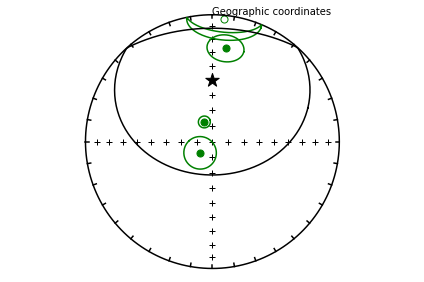

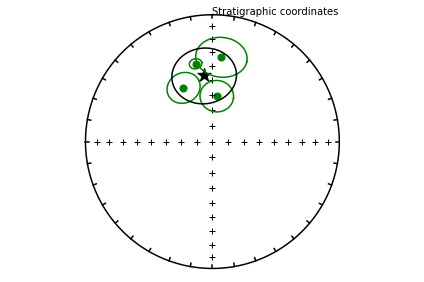

In [7]:
di_g =np.array([foldtestdata["Dg"], foldtestdata["Ig"]]).transpose()
alpha95_g = np.array([foldtestdata["alpha95"]])

di_s =np.array([foldtestdata["Ds"], foldtestdata["Is"]]).transpose()
alpha95_s = np.array([foldtestdata["alpha95.s"]])

means_g = fisher_sites_mean(di_g,alpha95_g,1, tc = False)
# saving plot to file
plt.savefig('test_g.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)
means_s = fisher_sites_mean(di_s,alpha95_s,2, tc = True)
# saving plot to file
plt.savefig('test_s.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)
means = pd.concat([means_g,means_s], axis =1).round(1)

means['Site']= "All sites mean"
means.columns.values[7]='n.s'
means.columns.values[10:14]=['r.s', 'k.s', 'alpha95.s','csd.s']

sites_and_means = pd.concat([foldtestdata,means],ignore_index=True)
sites_and_means

# saving plot to file
#plt.savefig('test.pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format='pdf',
#        transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None)

### Save excel file

In [8]:
outputfile = "mean_of_sites.xlsx"
export_file = ''
print('save and overwrite', "mean_of_sites.xlsx?")
while export_file != "y" and export_file != "n":
    export_file = str(input("(y/n)?:"))
    if export_file == 'y':
        sites_and_means.to_excel(outputfile)
        print("file saved to mean_of_sites.xlsx")
    else:
        pass

save and overwrite mean_of_sites.xlsx?
(y/n)?:n


### Bootstrap Fold test (Tauxe and Watson, 1994)

In [9]:
'''
help(ipmag.bootstrap_fold_test)
'''

'\nhelp(ipmag.bootstrap_fold_test)\n'

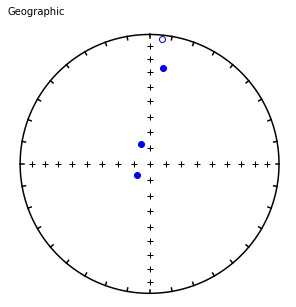

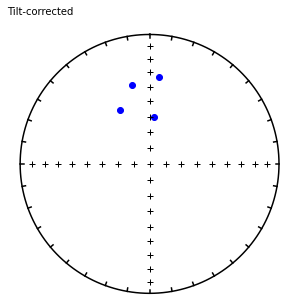

doing  1000  iterations...please be patient.....

tightest grouping of vectors obtained at (95% confidence bounds):
70 - 119 percent unfolding
range of all bootstrap samples: 
1  -  119 percent unfolding


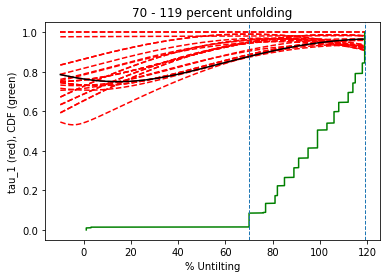

plot saved to bootstrap_CDF.pdf


In [10]:
#build input array with (dec_g, inc_g, bedding_dipdir, bedding_inc)
bedding = di_bedding(di_g,di_s) #call function to calculate bedding from (Dg Ig) (Ds Is)
data = np.concatenate((di_g, bedding), axis = 1)

ipmag.bootstrap_fold_test(data, save = True, fmt = 'pdf', num_sims=1000)
# saving plot to file
print('plot saved to bootstrap_CDF.pdf')


### Synfolding test

In [11]:
di_g

array([[  5.6,  -3.1],
       [227.6,  79.3],
       [  8. ,  26.4],
       [337.7,  76.4]])

In [12]:
di_g.transpose()[0]

array([  5.6, 227.6,   8. , 337.7])

In [13]:
#calculate syn_Ds syn_I at 5% steps from D I dipdir dip

dip_direction = bedding.transpose()[0]
dip = bedding.transpose()[1]
dec = di_g.transpose()[0]
inc = di_g.transpose()[1]
#data = ipmag.make_diddd_array(dec,inc,dip_direction,dip)
synfolding_df = pd.DataFrame()
n = -50
while n <= 150:
    #calculate partial untilt D I with function
    syn_dip = [element*(n/100) for element in dip]  # list comprehension
    data = ipmag.make_diddd_array(dec,inc,dip_direction,syn_dip)
    Dsyn,Isyn=pmag.dotilt_V(data) # rotate them
    di_block = np.array([Dsyn,Isyn]).transpose()
    syn_mean = syn_fisher_means(di_block)    #calculate fisher mean of partial untilt stage n with function
    df = pd.DataFrame(syn_mean, index =[n]) #save results in a row of dataframe
    synfolding_df = synfolding_df.append(df)
    n = n + 5

synfolding_df = synfolding_df.round(2)
synfolding_df[['dec','inc']] = synfolding_df[['dec','inc']].round(0)    
synfolding_df.index.name = '%unfolding'
synfolding_df

,dec,inc,n,r,k,alpha95,csd
%unfolding,,,,,,,
-50,187.0,39.0,4,3.26,4.05,52.37,40.24
-45,188.0,40.0,4,3.19,3.70,55.65,42.11
-40,188.0,40.0,4,3.12,3.39,59.10,43.97
-35,189.0,40.0,4,3.04,3.12,62.75,45.84
-30,190.0,40.0,4,2.96,2.88,66.62,47.72
-25,190.0,40.0,4,2.88,2.67,70.74,49.58
-20,191.0,40.0,4,2.79,2.48,75.16,51.45
-15,1.0,50.0,4,2.81,2.53,73.84,50.91
-10,1.0,50.0,4,2.90,2.73,69.46,49.02


### Save excel file

In [14]:
outputfile = "synfolding.xlsx"
export_file = ''
print('save and overwrite', "synfolding.xlsx?")
while export_file != "y" and export_file != "n":
    export_file = str(input("(y/n)?:"))
    if export_file == 'y':
        synfolding_df.to_excel(outputfile)
        print("file saved to synfolding.xlsx")
    else:
        pass

save and overwrite synfolding.xlsx?
(y/n)?:n


<Figure size 432x288 with 0 Axes>

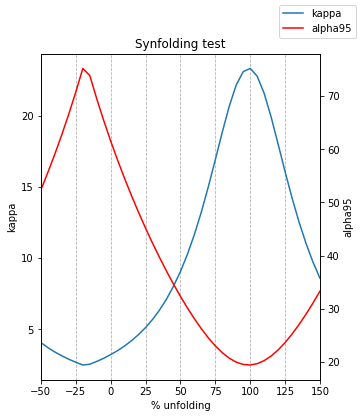

In [15]:
#Plot kappa (left) and a95 (right)
fig = plt.figure()  # an empty figure with no Axes
fig, ax1 = plt.subplots(figsize = (5,6))
ax1.set_xlim(-50, 150)
ax1.set_title("Synfolding test")  # Add a title to the axes.
ax1.plot(synfolding_df['k'], label = 'kappa')
ax1.set_xlabel('% unfolding')  # Add an x-label to the axes.
ax1.set_ylabel('kappa')  # Add an y-label to the axes.
ax1.grid(which='major', axis='x', linestyle='--')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(synfolding_df['alpha95'], label='alpha95', color = 'red')
ax2.set_ylabel('alpha95')  # Add an y-label to the axes.

fig.legend()
fig.savefig("synfolding.png")